This is used in the paper **Flexible cable routing framework for wind farm collection system optimization**.

## Preamble

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
import numpy as np
from pony import orm
import xarray as xr

In [3]:
from interarray.dbmodelv2 import open_database
from interarray.storagev2 import G_from_routeset
from interarray.plotting import gplot

In [4]:
plt.style.use('jupyter_dark')

In [5]:
%config InlineBackend.figure_formats = ['svg']
plt.rcParams['svg.fonttype'] = 'none'

## Setup

In [6]:
db = open_database('MILP_model_comparison.v2.sqlite')

In [7]:
handle_from_name = {
    'BIG Ronne Bank North': 'rbn',
    'Ormonde': 'ormonde',
    'BIG Ronne Bank South': 'rbs',
    'DanTysk': 'dantysk',
    'Horns Rev 1': 'horns',
    'Thanet': 'thanet',
    'West of Duddon Sands': 'sands',
    'Anholt': 'anholt',
    'SynthTess': 'tess',
    'London Array': 'london',
    'SynthTess (3 OSS)': 'tess3',
}

## Axes definition

In [8]:
Ns_q = db.NodeSet.select()

In [9]:
name2handle = dict((ns.name, next(iter(ns.RouteSets)).handle) for ns in Ns_q)
name2handle

{'BIG Ronne Bank North': 'rbn',
 'Ormonde': 'ormonde',
 'BIG Ronne Bank South': 'rbs',
 'DanTysk': 'dantysk',
 'Horns Rev 1 legacy': 'horns',
 'Thanet': 'thanet',
 'West of Duddon Sands': 'sands',
 'Anholt legacy': 'anholt',
 'SynthTess': 'tess',
 'London Array legacy': 'london',
 'SynthTess (3 OSS)': 'tess3'}

In [10]:
node_count = {handle: db.NodeSet.get(name=name).T
              for name, handle in name2handle.items()}
handleAx = list(node_count.keys())
handleAx.sort(key=lambda k: node_count[k])
handleAx

['rbn',
 'ormonde',
 'rbs',
 'dantysk',
 'horns',
 'thanet',
 'sands',
 'anholt',
 'tess',
 'london',
 'tess3']

In [11]:
capacityLim = (3, 16)
capacityAx = list(range(*capacityLim))
capacityAx

[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [12]:
solverAx = ['global_optimizer', 'MILP']

In [13]:
data = 'length', 'graph', 'runtime'
dims= 'handle', 'capacity', 'solver'
shape = len(handleAx), len(capacityAx), len(solverAx)
optima = xr.Dataset(data_vars=dict(length=(dims, np.full(shape, np.nan)),
                                   graph=(dims, np.empty(shape, dtype=object)),
                                   runtime=(dims, np.full(shape, np.nan))),
                    coords=dict(zip(dims, (handleAx, capacityAx, solverAx))))

## Fetch data from database

In [14]:
for method_idx in solverAx:
    with orm.db_session:
        for rs in db.RouteSet.select(
            lambda rs:
            rs.creator.startswith(method_idx)
        ):
            idx = (rs.handle, rs.capacity, method_idx)
            print(idx, rs.length)
            optima.length.loc[idx] = rs.length
            G = G_from_routeset(rs)
            optima.graph.loc[idx].values.__setitem__((), G)
            optima.runtime.loc[idx] = rs.runtime

('rbn', 3, 'global_optimizer') 33298.17836033638
('rbn', 4, 'global_optimizer') 29860.204861551734
('rbn', 5, 'global_optimizer') 28423.402888795787
('rbn', 6, 'global_optimizer') 27716.325905266214
('rbn', 7, 'global_optimizer') 27168.285951533515
('rbn', 8, 'global_optimizer') 26552.257544399687
('rbn', 9, 'global_optimizer') 26552.244636810836
('rbn', 10, 'global_optimizer') 26201.089671194622
('rbn', 11, 'global_optimizer') 26201.086106804836
('rbn', 12, 'global_optimizer') 26156.787801059225
('rbn', 13, 'global_optimizer') 25805.619229896412
('ormonde', 3, 'global_optimizer') 29324.48987050354
('ormonde', 4, 'global_optimizer') 24688.407433332213
('ormonde', 5, 'global_optimizer') 21429.106016125974
('ormonde', 6, 'global_optimizer') 19474.12162862974
('ormonde', 7, 'global_optimizer') 18039.395753991095
('ormonde', 8, 'global_optimizer') 16921.93611519869
('ormonde', 9, 'global_optimizer') 16921.93611519869
('ormonde', 10, 'global_optimizer') 16921.93611519869
('ormonde', 11, 'gl

### runtime

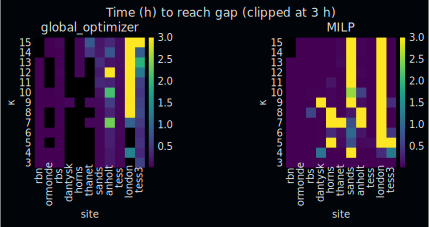

In [15]:
fig, axs = plt.subplots(1, len(solverAx))
fig.suptitle('Time (h) to reach gap (clipped at 3 h)')
for solver, ax in zip(solverAx, axs):
    img = ax.matshow(
        np.clip(optima.runtime.sel(solver=solver).values.T, 0, 10800)/3600,
        origin='lower')
    ax.tick_params(top=False, labeltop=False, bottom=True, labelbottom=True)
    ax.set_xlabel('site')
    ax.set_xticks(range(len(optima.handle)), optima.handle.data, rotation='vertical')
    ax.set_ylabel(r'$\kappa$')
    ax.set_yticks(range(len(optima.capacity)), range(*capacityLim))
    divider = make_axes_locatable(ax)
    # cax = divider.append_axes("top", size="5%", pad=0.05)
    # plt.colorbar(img, cax=cax, orientation='horizontal', location='top')
    # cax.set_title(Title[i])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(img, cax=cax, orientation='vertical')
    ax.set_title(solver)
    ax.grid(False)

### total length

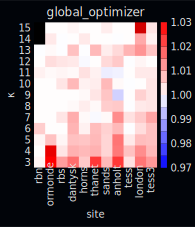

In [16]:
reference = optima.length.sel(solver='MILP').values.T
fig, axs = plt.subplots(1, len(solverAx) - 1)
if len(solverAx) == 2:
    axs = [axs]
divnorm=plt.cm.colors.TwoSlopeNorm(vmin=0.94, vcenter=1., vmax=1.06)
for solver, ax in zip(['global_optimizer'], axs):
    img = ax.matshow(optima.length.sel(solver=solver).values.T/reference, origin='lower', cmap=plt.cm.seismic, norm=divnorm)#(np.linspace(0.97, 1.03, 13)))
    ax.tick_params(top=False, labeltop=False, bottom=True, labelbottom=True)
    ax.set_xlabel('site')
    ax.set_xticks(range(len(optima.handle)), optima.handle.data, rotation='vertical')
    ax.set_ylabel(r'$\kappa$')
    ax.set_yticks(range(len(optima.capacity)), range(*capacityLim))
    divider = make_axes_locatable(ax)
    # cax = divider.append_axes("top", size="5%", pad=0.05)
    # plt.colorbar(img, cax=cax, orientation='horizontal', location='top')
    # cax.set_title(Title[i])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(img, cax=cax, orientation='vertical',
                 boundaries=np.linspace(0.97, 1.03, 13),
                )
    ax.set_title(solver)
    ax.grid(False)

## Instances where Perez-Rua 2020 is shorter than our B&C result

In [17]:
solverAx

['global_optimizer', 'MILP']

In [18]:
juru_is_better = ((optima.length[:,:, 0]/optima.length[:,:, 1] - 1) < -5e-4)
juru_is_better.to_pandas()

capacity,3,4,5,6,7,8,9,10,11,12,13,14,15
handle,,,,,,,,,,,,,
rbn,False,False,False,False,False,False,False,False,False,False,False,False,False
ormonde,False,False,False,False,False,False,False,False,False,False,False,False,False
rbs,False,False,False,False,False,False,False,False,False,False,False,False,False
dantysk,False,False,False,False,False,False,False,False,False,False,False,False,False
horns,False,False,False,False,False,False,False,False,False,True,False,False,False
thanet,False,False,False,False,True,False,False,False,False,False,False,False,False
sands,False,False,False,False,False,False,False,False,True,False,False,False,False
anholt,False,False,False,False,False,False,True,False,True,False,False,False,False
tess,False,False,False,False,False,False,False,False,False,False,False,False,False


In [19]:
juru_is_better.sum().item()

5

In [20]:
merit = optima.length[:,:, 1]/optima.length[:,:, 0] - 1
merit.min().item(), merit.max().item()

(-0.038798549578038966, 0.0054209425428310976)

In [21]:
juru_idx = np.argwhere(juru_is_better.data)
juru_idx

array([[4, 9],
       [5, 4],
       [6, 8],
       [7, 6],
       [7, 8]])

In [22]:
for handle_idx, κ_idx in juru_idx:
    length_juru = optima.length[handle_idx, κ_idx, 0].item()
    solver_idx = 1
    length_contestant = optima.length[handle_idx, κ_idx, solver_idx].item()
    G = optima.graph[handle_idx, κ_idx, 0].item()
    for _, _, r in G.edges(data="rogue"):
        if r is not None:
            print(handle_idx, κ_idx)
    num_rogues = sum(1 for _, _, kind in G.edges(data='kind') if kind == 'rogue')
    print(f'{length_juru:.0f} -> {length_contestant:.0f} '
          f'({solverAx[solver_idx]}) '
          f'{100*(length_contestant/length_juru - 1):+.2f}% '
          f'{handleAx[handle_idx]}, κ = {κ_idx + 3}, '
          f'num_rogues = {num_rogues}')

50831 -> 50867 (MILP) +0.07% horns, κ = 12, num_rogues = 0
61455 -> 61504 (MILP) +0.08% thanet, κ = 7, num_rogues = 0
88470 -> 88657 (MILP) +0.21% sands, κ = 11, num_rogues = 0
138262 -> 139011 (MILP) +0.54% anholt, κ = 9, num_rogues = 2
122181 -> 122371 (MILP) +0.16% anholt, κ = 11, num_rogues = 2


In [23]:
num_instances = (optima.length[:,:, 0].size - optima.length[:,:, 0].isnull().sum()).item()
num_instances

141

In [24]:
merit.median().item()

-0.0024347664901663846

## Create quality comparison plots

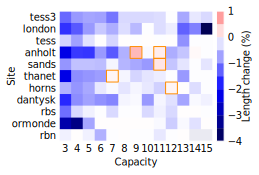

In [25]:
with plt.style.context('pdf_1col'):
    fig, ax = plt.subplots(facecolor='w')
    divnorm=plt.cm.colors.TwoSlopeNorm(vmin=-4, vcenter=0., vmax=4)
    img = ax.matshow(100*merit, origin='lower', cmap=plt.cm.seismic, norm=divnorm)
    ax.tick_params(top=False, labeltop=False, bottom=True, labelbottom=True)
    ax.set_ylabel('Site')
    ax.set_yticks(range(len(optima.handle)), optima.handle.data)
    ax.set_xlabel('Capacity')
    ax.set_xticks(range(len(optima.capacity)), range(*capacityLim))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(img, cax=cax, orientation='vertical',
                 boundaries=np.linspace(-4, 1, 11),
                )
    cax.set_ylabel('Length change (%)')
    ax.scatter(*juru_idx.T[::-1], marker='s',
               facecolor='none', color='darkorange', s=140)
    ax.grid(False)

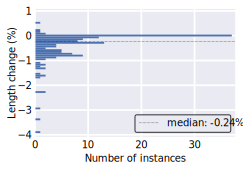

In [26]:
with plt.style.context('pdf_1col'):
    fig, ax = plt.subplots(facecolor='w')
    hist = ax.hist((100*merit.data).flat, orientation='horizontal', bins=np.linspace(-4, 1, 69),
                   edgecolor='none');
    median = 100*merit.median().item()
    ax.axhline(median, *ax.get_xlim(), color='k', ls=':', lw=0.5,
               label=f'median: {median:.2f}%')
    ax.legend(loc='lower right')
    ax.set_ylabel('Length change (%)')
    ax.set_xlabel('Number of instances')

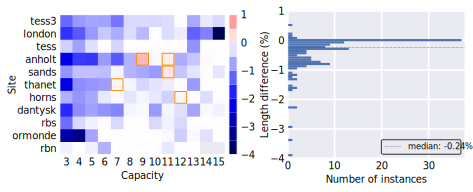

In [27]:
with plt.style.context('pdf_2col'):
    fig, (ax, ax2) = plt.subplots(1, 2, facecolor='w', gridspec_kw={'wspace':  0.1})
    divnorm = plt.cm.colors.TwoSlopeNorm(vmin=-4, vcenter=0., vmax=4)
    img = ax.matshow(100*merit, origin='lower', cmap=plt.cm.seismic, norm=divnorm)
    ax.tick_params(top=False, labeltop=False, bottom=True, labelbottom=True)
    ax.set_ylabel('Site')
    ax.set_yticks(range(len(optima.handle)), optima.handle.data)
    ax.set_xlabel('Capacity')
    ax.set_xticks(range(len(optima.capacity)), range(*capacityLim))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(img, cax=cax, orientation='vertical',
                 boundaries=np.linspace(-4, 1, 11))
    ax.scatter(*juru_idx.T[::-1], marker='s',
               facecolor='none', color='darkorange', s=140)
    ax.grid(False)

    hist = ax2.hist((100*merit.data).flat, orientation='horizontal', bins=np.linspace(-4, 1, 69),
                   edgecolor='none');
    median = 100*merit.median().item()
    ax2.axhline(median, *ax.get_xlim(), color='k', ls=':', lw=0.5,
                label=f'median: {median:.2f}%')
    ax2.legend(loc='lower right', fontsize='small')
    ax2.set_ylabel('Length difference (%)')
    ax2.set_xlabel('Number of instances')
    ax2.set_ylim(-4, 1)
    fig.savefig('quality_comparison.pdf')

## Plot the instance with the highest positive difference

4.18, 1.95


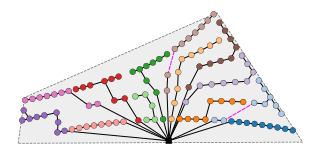

In [28]:
with plt.style.context('pdf_1col'):
    G = optima.graph.loc['anholt', 9, 'global_optimizer'].item()
    ax = gplot(G, infobox=False, legend=False, dark=False, figsize=(4.2, 50))
    ax.figure.canvas.draw()
    bbox = ax.get_window_extent().transformed(ax.figure.dpi_scale_trans.inverted())
    print(f'{bbox.width:.2f}, {bbox.height:.2f}')

In [29]:
ax.figure.savefig('anholt_9_ref.pdf', pad_inches=0., transparent=True)

4.18, 1.95


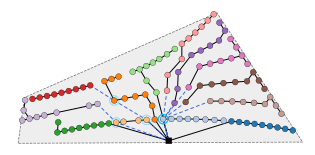

In [30]:
with plt.style.context('pdf_1col'):
    G = optima.graph.loc['anholt', 9, 'MILP'].item()
    ax = gplot(G, infobox=False, legend=False, dark=False, figsize=(4.2, 2.2))
    ax.figure.canvas.draw()
    bbox = ax.get_window_extent().transformed(ax.figure.dpi_scale_trans.inverted())
    print(f'{bbox.width:.2f}, {bbox.height:.2f}')

In [31]:
ax.figure.savefig('anholt_9_our.pdf', pad_inches=0., transparent=True)